In [1]:
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt

dfN = pd.read_csv("Taiwanese_Petitions.csv", encoding="utf-8")
dfN

,publishDate,網址,附議數量,content,權責機關,協辦單位,協辦單位2
0,2015-09-10 13:26:19,https://join.gov.tw/idea/detail/25824c17-f141-...,22,Join 平台應提供匯出資料供批次下載\n目前 Join 平台為方便機關人員作業，在後台有「...,國家發展委員會,NaN,NaN
1,2015-09-10 20:45:11,https://join.gov.tw/idea/detail/94b5dca9-57fc-...,2,都更的建議國家既然採多數決.為何總是被少數人綁架.都更常因釘子戶造成困擾.個人建議.國家要發...,內政部,NaN,NaN
2,2015-09-10 21:40:32,https://join.gov.tw/idea/detail/3bdab9bf-d874-...,184,引進鞭刑依先進國家如新加坡的刑法引進鞭刑讓重刑犯，強姦犯等重大罪犯得到應得的逞罰促進社會正義...,法務部,NaN,NaN
3,2015-09-11 00:46:34,https://join.gov.tw/idea/detail/41d9ffb1-21f3-...,10,"提高機車駕照取照標準並予以分類凡國民在年滿16歲後,可以申請並考取""電動機車""駕照.\n在連...",交通部,經濟部,環境部
4,2015-09-12 02:23:57,https://join.gov.tw/idea/detail/87354c05-f36e-...,52,敬請具體實踐中華民國憲法第143條：中華民國領土內之土地屬於國民全體。中華民國公有土地，兩則...,內政部,財政部,NaN
...,...,...,...,...,...,...,...
653,2021-12-08 00:29:19,https://join.gov.tw/idea/detail/eb7440a1-332a-...,7083,恢復《交通管理處罰條例》民眾得舉發所有靜態違規現行《交通管理處罰條例》第 7-1 條明定，民...,交通部,內政部,NaN
654,2021-12-19 18:42:40,https://join.gov.tw/idea/detail/39a7b4ab-12af-...,5693,「搶救抱卵母蟹、保護漁業資源，要求農委會修改現行管制辦法，全年禁止捕撈抱卵母蟹」2021年十...,農業部,NaN,NaN
655,2021-12-21 13:26:22,https://join.gov.tw/idea/detail/673b0691-5b8a-...,5150,反對移轉投票、不在籍投票反對移轉投票、不在籍投票 \n移轉投票、不在籍投票不論制度多完善，最...,內政部,中央選舉委員會,NaN
656,2021-12-30 00:36:32,https://join.gov.tw/idea/detail/e451c76b-88fd-...,5111,敦請政府立專法保障外送員工作權近幾年來外送產業崛起目前中央統計約有8萬8千人從事外送員 \n...,勞動部,經濟部,交通部


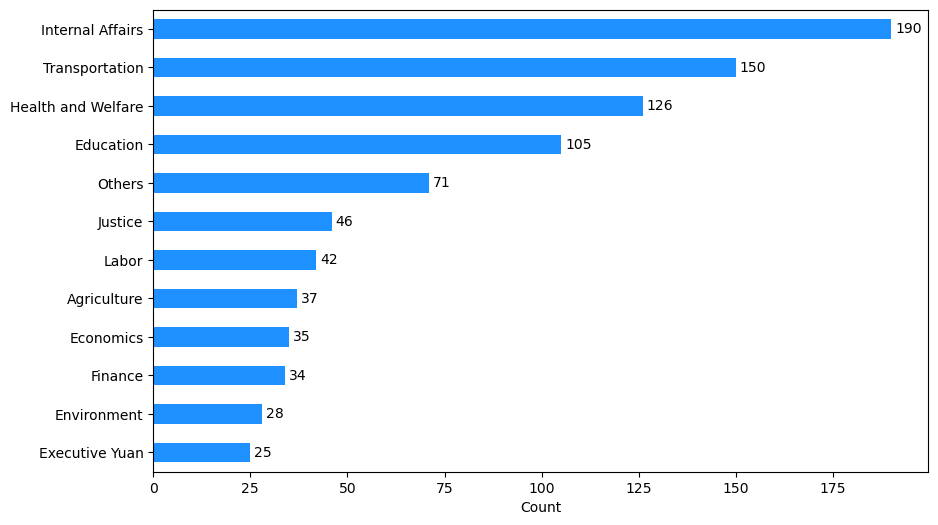

In [7]:
# Define a mapping from Chinese department names to English
department_translation = {
    "內政部": "Internal Affairs",
    "法務部": "Justice",
    "交通部": "Transportation",
    "環境部": "Environment",
    "衛生福利部": "Health and Welfare",
    "財政部": "Finance",
    "教育部": "Education",
    "經濟部": "Economics",
    "勞動部": "Labor",
    "農業部": "Agriculture",
    "行政院人事行政總處": "Executive Yuan",
    "其余": "Others"
}

# Rename the columns using the translation dictionary
dfN_renamed = dfN.rename(columns=department_translation)

# Select only the translated label columns (excluding 'content')
translated_label_columns = [department_translation.get(col, col) for col in dfN.columns if col in department_translation]

# Count the occurrences of each translated label
translated_label_counts = dfN_renamed[translated_label_columns].sum().sort_values(ascending=False)

# Plot the distribution with translated labels
plt.figure(figsize=(10, 6))
ax = translated_label_counts.plot(kind="barh", color="dodgerblue")

# Add value labels next to each bar
for i, (label, value) in enumerate(translated_label_counts.items()):
    ax.text(value + 1, i, str(int(value)), va='center', fontsize=10)

plt.xlabel("Count")
# plt.title("Distribution of label frequencies used in the training")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plot_filename = "Distribution.png"
plt.savefig(plot_filename, dpi=1200, bbox_inches="tight")

# Show the plot
plt.show()


In [208]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [274]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(dfN, random_state=1111, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=1111, test_size=0.50, shuffle=True)

In [275]:
df_train

,content,內政部,法務部,交通部,環境部,衛生福利部,財政部,教育部,經濟部,勞動部,農業部,行政院人事行政總處,其余
242,讓酒駕在台灣消失~ 以現有罰款金額為低消~ 若違規者為自有車輛~ 且月收入高於低消~ 罰金擇...,1,0,1,0,0,0,0,0,0,0,0,0
330,生活即政治：彈性工時/加班日的垃圾要怎麼倒？ 現階段的勞工實際工時過長、且臨時性的加班要求...,0,0,0,1,0,0,0,0,0,0,0,0
290,國民年金不應該是強制納保，應修改為由全體國民自己來決定是否要不要加入國民年金保險 \n 依照...,0,0,0,0,1,0,0,0,1,0,0,0
207,提議修改1138條中條文，修改成對於嫁出去的女兒不應享有父母親的遺產繼承權，沒嫁的女兒才有繼...,0,1,0,0,0,0,0,0,0,0,0,0
253,立法通過「國民營養法」建立國民正確飲食觀念，養成均衡飲食習慣，改善國民營養，增進國民健康(1...,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,針對”過失致死罪”刑法相關法條修法，恢復司法正義針對”過失致死罪”刑法立法院相關法條修法，恢...,0,1,0,0,0,0,0,0,0,0,0,0
396,委員、幹部委員資格1.公寓大廈管理條例裡未明確限定管委會委員不得有三等親內一起擔任委員。 \...,1,0,0,0,0,0,0,0,0,0,0,0
337,建商蓋的房屋，廁所應有對外窗，室內至少應有30坪等合理之規範。有了孩子之後，看了很多房子，建...,1,0,0,0,0,0,0,0,0,0,0,0
311,由家長監督性教育（一）增訂兒少福利法46-2條 \n高中以下學校應每年安排一次性知識及守貞課...,0,0,0,0,1,0,1,0,0,0,0,0


In [276]:
import pandas as pd

# Assuming df_train is your DataFrame
# Create a new list to store class distribution
class_distribution_list = []

# Iterate through columns dynamically
for column in df_train.columns:
    class_count = df_train[df_train[column] == 1][column].value_counts().to_dict()
    for label, count in class_count.items():
        class_distribution_list.append({'Class': column, 'Count': count})

# Convert list to DataFrame
class_distribution = pd.DataFrame(class_distribution_list)

# Sort the class_distribution DataFrame by the 'Count' column in descending order
class_distribution = class_distribution.sort_values(by='Count', ascending=False)

class_distribution


,Class,Count
0,內政部,132
2,交通部,102
4,衛生福利部,84
6,教育部,73
11,其余,48
1,法務部,30
8,勞動部,29
7,經濟部,27
5,財政部,26
9,農業部,25


In [277]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05


In [278]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('ZhangQianML/CnPBERT')
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (460, 13), Test: (99, 13), Valid: (99, 13)


In [279]:
#If you want to handle cases where the text is longer than the maximum sequence length allowed by the BERT model and you don't 
#want to truncate the text, you can split the text into smaller chunks and process each chunk separately. 
#This approach is known as "chunking" or "sliding window."# Test the tokenizer
test_text = "We are testing BERT tokenizer."

# Set the maximum sequence length
max_seq_length = 50

# Tokenize the text without truncation
tokens = tokenizer.tokenize(test_text)

# Split the tokens into chunks
chunks = [tokens[i:i + max_seq_length] for i in range(0, len(tokens), max_seq_length)]

# Initialize lists to store encodings
input_ids_list = []
attention_mask_list = []

# Process each chunk separately
for chunk in chunks:
    # Convert tokens to input_ids and attention_mask
    encoding = tokenizer.encode_plus(chunk, 
                                     add_special_tokens=True,
                                     max_length=max_seq_length,
                                     padding="max_length",
                                     return_attention_mask=True,
                                     return_tensors="pt")

    # Append the results to the lists
    input_ids_list.append(encoding["input_ids"])
    attention_mask_list.append(encoding["attention_mask"])

# Concatenate the results to get the final encoding
input_ids = torch.cat(input_ids_list, dim=0)
attention_mask = torch.cat(attention_mask_list, dim=0)

# Display the final encoding
print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)



Input IDs: tensor([[  101,   100,  8995, 10060,  8221,   100,  8228, 11285, 11789,  8180,
           119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [280]:
df_train['content']

242    讓酒駕在台灣消失~ 以現有罰款金額為低消~ 若違規者為自有車輛~ 且月收入高於低消~ 罰金擇...
330    生活即政治：彈性工時/加班日的垃圾要怎麼倒？　　現階段的勞工實際工時過長、且臨時性的加班要求...
290    國民年金不應該是強制納保，應修改為由全體國民自己來決定是否要不要加入國民年金保險 \n 依照...
207    提議修改1138條中條文，修改成對於嫁出去的女兒不應享有父母親的遺產繼承權，沒嫁的女兒才有繼...
253    立法通過「國民營養法」建立國民正確飲食觀念，養成均衡飲食習慣，改善國民營養，增進國民健康(1...
                             ...                        
152    針對”過失致死罪”刑法相關法條修法，恢復司法正義針對”過失致死罪”刑法立法院相關法條修法，恢...
396    委員、幹部委員資格1.公寓大廈管理條例裡未明確限定管委會委員不得有三等親內一起擔任委員。 \...
337    建商蓋的房屋，廁所應有對外窗，室內至少應有30坪等合理之規範。有了孩子之後，看了很多房子，建...
311    由家長監督性教育（一）增訂兒少福利法46-2條 \n高中以下學校應每年安排一次性知識及守貞課...
412    修改性別平等教育法的『多元性別』為『兩性』性別平等教育，有其良善的立法精神。在第 1 條就寫...
Name: content, Length: 460, dtype: object

In [281]:
import torch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['content'])
        self.targets = self.df[target_list].values
        self.targets = self.targets.astype(float)

        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
            
        
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }


In [282]:
target_list = list(dfN.columns)
target_list


['content',
 '內政部',
 '法務部',
 '交通部',
 '環境部',
 '衛生福利部',
 '財政部',
 '教育部',
 '經濟部',
 '勞動部',
 '農業部',
 '行政院人事行政總處',
 '其余']

In [283]:
target_list = target_list[1:]
target_list

['內政部',
 '法務部',
 '交通部',
 '環境部',
 '衛生福利部',
 '財政部',
 '教育部',
 '經濟部',
 '勞動部',
 '農業部',
 '行政院人事行政總處',
 '其余']

In [284]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [285]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([ 101, 6366, 6983, 7690, 1762, 1378, 4124, 3867, 1927,  172,  809, 4412,
         3300, 5391, 3621, 7032, 7540, 4158,  856, 3867,  172, 5735, 6889, 6211,
         5442, 4158, 5632, 3300, 6722, 6739,  172,  684, 3299, 3119, 1057, 7770,
         3176,  856, 3867,  172, 5391, 7032, 3079, 7770, 5391, 3621,  172, 2769,
         2990, 6359,  769, 6858, 6889, 6211, 5391, 3621,  172, 3300,  856, 3867,
         4192,  677, 7361,  172,  809, 4412, 3300, 5391, 3621, 7032, 7540, 4158,
          856, 3867,  172, 5735, 6889, 6211, 5442, 4158, 5632, 3300, 6722, 6739,
          172,  684, 3299, 3119, 1057, 7770, 3176,  856, 3867,  172, 5391, 7032,
         3079, 7770, 5391, 3621,  172,  172,  172,  809, 4412, 1762, 4638, 1825,
         3315, 5959, 6536, 8202, 8156, 1039,  117, 5018,  671, 3613, 6983, 7690,
          125,  119,  126, 5857,  117, 2347, 5195, 2571,  753,  943, 3299, 4638,
         5959, 3717,  117, 1377, 3221, 2205, 3176,  671,  763, 3300, 7092,  782,
          889, 

In [286]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [287]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('ZhangQianML/CnPBERT', return_dict=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(768, 12)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at ZhangQianML/CnPBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [288]:
import pandas as pd

# Assuming df_train is your DataFrame
# Create a new list to store class distribution
class_distribution_list = []

# Iterate through columns dynamically
for column in df_train.columns:
    class_count = df_train[df_train[column] == 1][column].value_counts().to_dict()
    for label, count in class_count.items():
        class_distribution_list.append({'Class': column, 'Count': count})

# Convert list to DataFrame
class_distribution = pd.DataFrame(class_distribution_list)

# Sort the class_distribution DataFrame by the 'Count' column in descending order
class_distribution = class_distribution.sort_values(by='Count', ascending=False)

class_distribution

,Class,Count
0,內政部,132
2,交通部,102
4,衛生福利部,84
6,教育部,73
11,其余,48
1,法務部,30
8,勞動部,29
7,經濟部,27
5,財政部,26
9,農業部,25


In [289]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming class_counts is a tensor containing the counts for each class
#class_counts = torch.tensor([140, 28, 112, 18, 76, 26, 77, 18, 26, 28, 22, 50], dtype=torch.float)
#class_weights = 1.0 / class_counts

# Move to device
#class_weights = class_weights.to(device)

# Clip extreme values (optional)
#class_weights = torch.clamp(class_weights, max=5.0)  # Prevent instability

# Define loss function using pos_weight (recommended for multi-label classification)
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)


In [290]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [291]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)   


C:\Users\danil\anaconda3\envs\multilabel\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [292]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [293]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

#Model Training

In [294]:
import os

history = defaultdict(list)
best_accuracy = 0
best_model = None

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the model for the current epoch
    model_name = f"TaiwanPetitions-{epoch}epoch{'s' if epoch > 1 else ''}"
    torch.save(model.state_dict(), model_name) 


Epoch 1/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=3.1030, val_loss=3.3261 train_acc=0.5730, val_acc=0.6574
Epoch 2/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=2.8803, val_loss=3.1710 train_acc=0.6460, val_acc=0.6338
Epoch 3/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=2.7123, val_loss=2.9229 train_acc=0.6406, val_acc=0.6684
Epoch 4/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=2.3446, val_loss=2.6629 train_acc=0.6920, val_acc=0.7205
Epoch 5/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=2.0674, val_loss=2.4876 train_acc=0.7324, val_acc=0.7710
Epoch 6/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=1.8351, val_loss=2.3578 train_acc=0.7516, val_acc=0.7677
Epoch 7/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=1.6241, val_loss=2.2252 train_acc=0.7656, val_acc=0.7786
Epoch 8/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=1.4363, val_loss=2.0772 train_acc=0.7632, val_acc=0.7736
Epoch 9/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=1.2819, val_loss=2.0473 train_acc=0.7734, val_acc=0.7652
Epoch 10/10


  0%|          | 0/15 [00:00<?, ?it/s]

train_loss=1.1641, val_loss=2.0404 train_acc=0.7712, val_acc=0.7727


In [295]:
# Loading the best model
model = BERTClass()
model.load_state_dict(torch.load('TaiwanPetitions-10epochs'))
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at ZhangQianML/CnPBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\danil\AppData\Local\Temp\ipykernel_28344\1390497093.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializatio

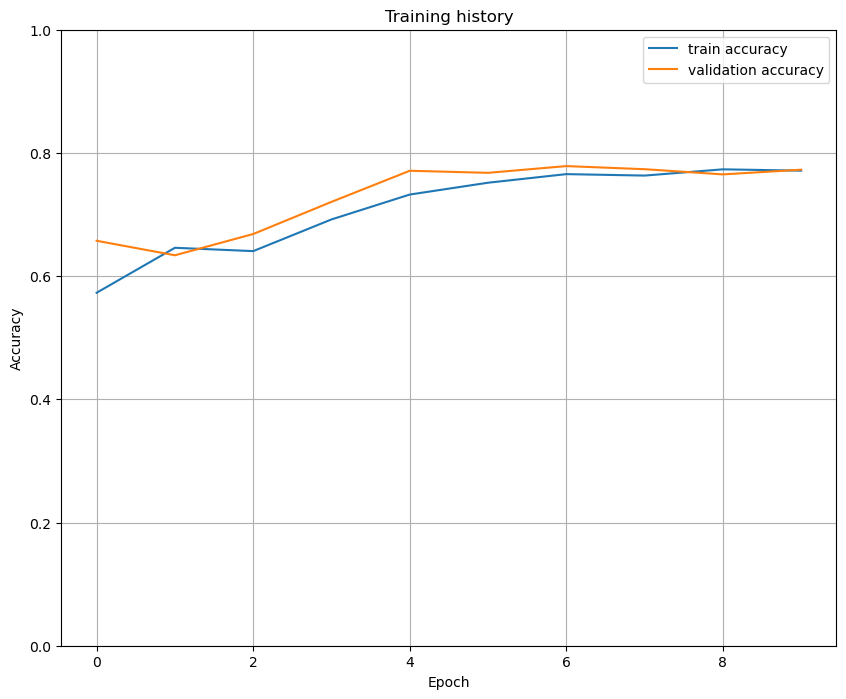

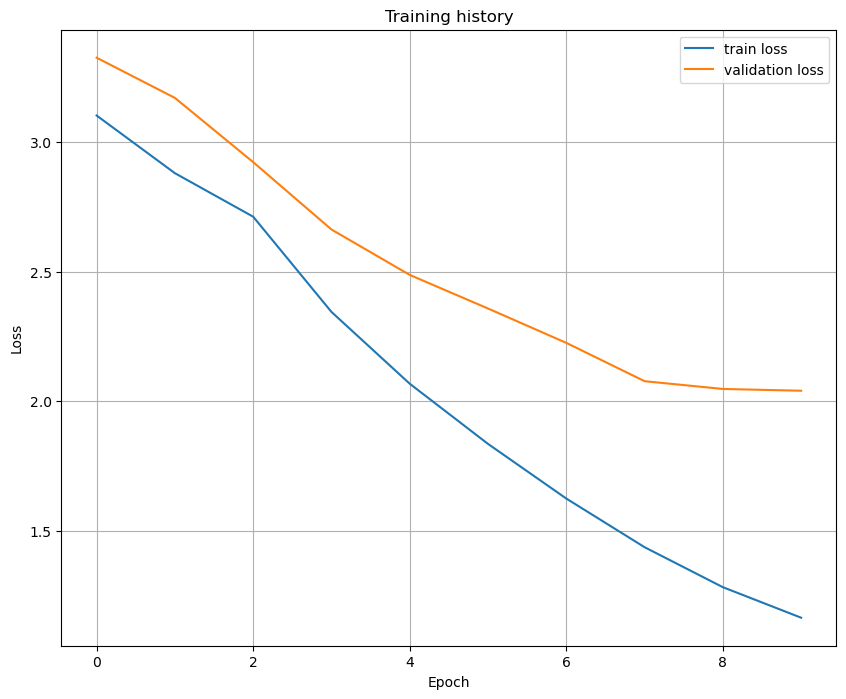

In [296]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

plt.figure(figsize=(10, 8))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.show()

In [297]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)
test_acc

0.765993265993266

In [298]:

train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)



In [305]:
#To ensure that only the top three classes with the highest scores and above the threshold are assigned a value of 1

def get_predictions(model, data_loader, threshold=0.8, top_k=2):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data["targets"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).detach().cpu()

            # Find indices of values above the threshold
            above_threshold = outputs > threshold

            # Get the indices of the top k values among those above the threshold
            topk_indices = torch.topk(outputs * above_threshold, k=top_k, dim=1).indices

            # Create a binary tensor with 1s at the top k indices
            preds = torch.zeros_like(outputs)
            preds.scatter_(1, topk_indices, 1)

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)



In [306]:

#out of 30 epochs model with 22 epochs was selected

import torch
from sklearn.metrics import classification_report

# Assuming predictions and target_values are PyTorch tensors on the GPU
predictions_cpu = predictions.cpu().numpy()
target_values_cpu = target_values.cpu().numpy()

# Now, you can use the classification_report function
print(classification_report(target_values_cpu, predictions_cpu, target_names=target_list))

              precision    recall  f1-score   support

         內政部       0.35      0.97      0.51        30
         法務部       0.24      1.00      0.38         4
         交通部       0.79      1.00      0.88        22
         環境部       1.00      1.00      1.00         3
       衛生福利部       0.94      0.74      0.83        23
         財政部       0.67      0.67      0.67         3
         教育部       0.79      0.88      0.83        17
         經濟部       0.33      0.33      0.33         3
         勞動部       1.00      0.86      0.92         7
         農業部       1.00      1.00      1.00         5
   行政院人事行政總處       0.00      0.00      0.00         6
          其余       0.50      0.31      0.38        16

   micro avg       0.55      0.78      0.65       139
   macro avg       0.63      0.73      0.65       139
weighted avg       0.65      0.78      0.67       139
 samples avg       0.55      0.85      0.64       139



In [441]:
# Get the text
c= 50
text = test_dataset[c]['title']

# Get actual labels
actual_indices = [i for i, val in enumerate(target_values[c]) if val == 1]
actual_labels = [target_list[i] for i in actual_indices]

# Get predicted labels
threshold = 0.8
predicted_indices = [i for i, val in enumerate(predictions[c]) if val == 1 and prediction_probs[c][i] > threshold]
predicted_labels = [(target_list[i], prediction_probs[c][i].item()) for i in predicted_indices]

# Print the formatted output
print(f"Text: {text}\n")
print(f"Actual Labels: {actual_labels}\n")
print("Predicted Labels:")
for label, prob in predicted_labels:
    print(f"{label}: {prob:.4f}")


Text: 反對新北市瑞芳區深澳電廠擴建反對新北市瑞芳區深澳電廠擴建台電和環評委員不能因發電而忽略北北基市民健康，這次深澳電等於是一個全新的燃煤電廠，不但引起許多環保團體、環保人士關注，也引發北北基市民對於健康及空汙的疑慮。基於對北北基市民未來健康，以及考慮未來推動綠能和乾淨能源等世界趨勢，籲請政府及台電勿一意孤行，枉置北北基市民健康於不顧。

Actual Labels: ['環境部', '經濟部']

Predicted Labels:
環境部: 0.8780
經濟部: 0.8373


In [307]:
import gc
torch.cuda.empty_cache()
gc.collect()

0